In [ ]:
import torch
from matplotlib import pyplot as plt
from flow_matching.latent.training_vae_cond import CondVAETrainer
from flow_matching.whar.stft import istft_transform, plot_spectrogram_grid
from flow_matching.whar.sampler import WHARSamplerRAW
from flow_matching.whar.vae_cond import CondSpectrogramVAE
from flow_matching.whar.vae_losses import (
    vae_loss_mse,
    vae_loss_log_mag,
    vae_loss_log_mag_phase,
    vae_loss_spect_conv,
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sampler = WHARSamplerRAW()

Creating config hash...
Checking download...
Download exists.
Checking sessions...
Sessions exist.
Validating common format...
[########################################] | 100% Completed | 757.66 ms
Common format validated.
Checking windowing...
Loading config hash...
Windowing exists.
subject_ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
activity_ids: [0 1 2 3 4 5]
train: 7046 | val: 782 | test: 1671
Postprocessing...


Loading windows: 100%|██████████| 9499/9499 [00:07<00:00, 1289.96it/s]


Getting normalization parameters...
Loading config hash...
Creating normalization parameters hash...
Loading normalization parameters hash...


Loading samples: 100%|██████████| 9499/9499 [00:02<00:00, 4239.86it/s]


In [5]:
vae = CondSpectrogramVAE()
trainer = CondVAETrainer(
    vae, sampler.train_loader, sampler.val_loader, vae_loss_mse, track=True
)

In [ ]:
trainer.train(num_epochs=30, device=device, lr=1e-3)

In [14]:
torch.save(vae.state_dict(), "cond_vae.pt")

In [6]:
vae.load_state_dict(torch.load("cond_vae.pt"))

<All keys matched successfully>

tensor(6.4622, grad_fn=<MaxBackward1>) tensor(-5.7085, grad_fn=<MinBackward1>)


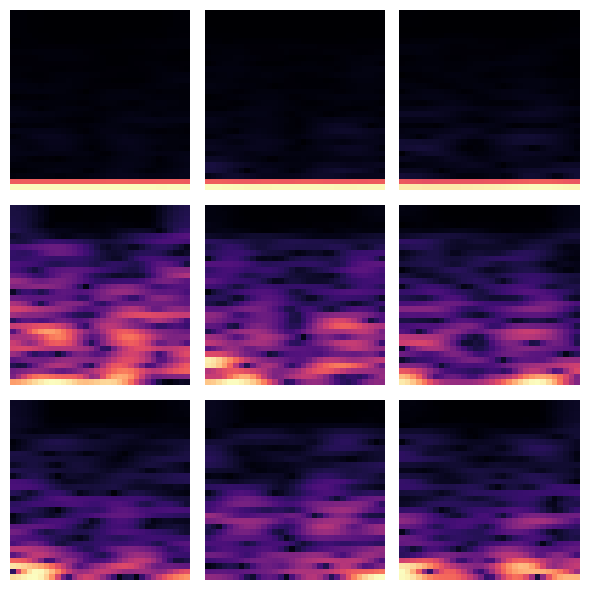

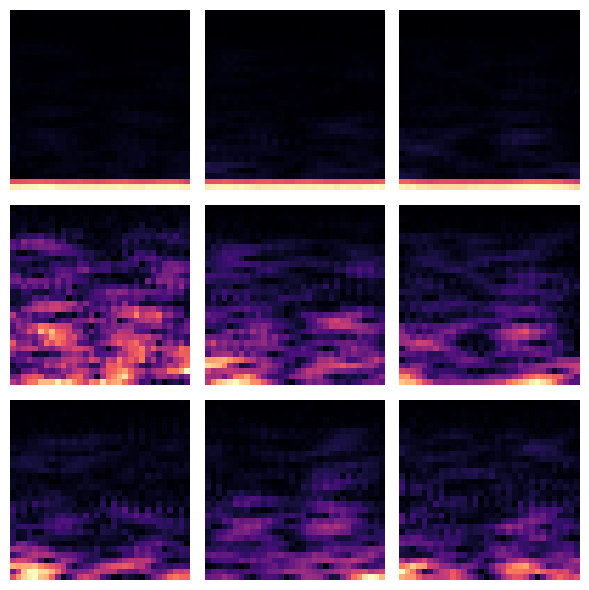

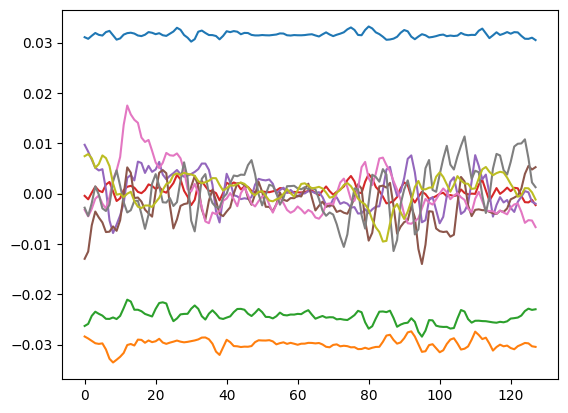

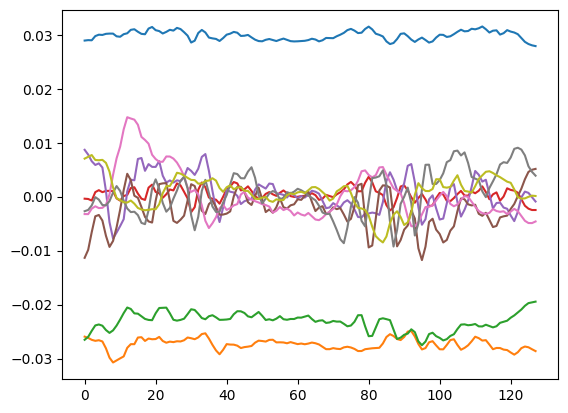

In [ ]:
from flow_matching.whar.stft import decompress_stft


x, y = next(iter(sampler.train_loader))
mu, logvar = vae.encoder(x.to(device), y.to(device))

# z = vae.reparameterize(mu, logvar)
out = vae.decoder(mu, y.to(device))
B, C, H, W = out.shape
out = out.reshape(B, C // 2, 2, H, W)[0].detach().cpu()


plot_spectrogram_grid(x.reshape(B, C // 2, 2, H, W)[0])
plot_spectrogram_grid(out)


recon = istft_transform(decompress_stft(x.reshape(B, C // 2, 2, H, W)[0]))
plt.plot(recon)
plt.show()

recon = istft_transform(decompress_stft(out))
plt.plot(recon)
plt.show()